# Higgs Inflation: Detailed Scan of Initial Conditions for USR

We previously observed that the onset of the USR phase ($\eta \approx -6$) occurs at initial velocities $|y_i| \approx 10^{-4}$, which is much lower than the naive kinetic dominance estimate ($|y| \sim 0.4$).

In this notebook, we perform a **high-resolution scan** around this transition region and introduce new visualizations to better understand the dynamics.

## 1. High-Resolution Parameter Scan
We will scan $|y_i|$ and record the full evolution of $\eta_{USR}(N)$. This allows us to see not just *if* USR occurs, but *when* and for *how long*.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from inflation_models import HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

## 2. Visualization Method: The "Eta Heatmap"

Instead of reducing each run to a single number (min $\eta$), we will create a 2D map:
- **X-axis:** Number of e-folds ($N$)
- **Y-axis:** Initial Velocity ($|y_i|$)
- **Color:** Value of $\eta_{USR}$

This visualization (often called a waterfall plot or phase diagram) reveals the "shape" of the attractor basin.

In [6]:
# Define the scan range
# We focus on the transition region 1e-6 to 1e-3, plus some higher values
y_values = -np.logspace(-6, -2, 100)
phi_i = 12.0

# Common N grid for interpolation (to build the heatmap)
N_grid = np.linspace(0, 5, 200)
eta_matrix = np.zeros((len(y_values), len(N_grid)))

print(f"Running {len(y_values)} simulations...")

for i, y in enumerate(y_values):
    model = HiggsModel()
    model.xi = phi_i
    model.yi = y
    
    # Run short simulation
    T_span = np.linspace(0, 500, 2000)
    sol = run_background_simulation(model, T_span)
    data = get_derived_quantities(sol, model)
    
    # Calculate eta_USR
    N_run = data['N']
    eta_run = 2 * (data['epsH'] - data['etaH'])
    
    # Interpolate onto common grid
    # We use fill_value to handle cases where N(t) might be slightly different ranges
    # but for short times on plateau, N usually starts at 0 and grows.
    if N_run[-1] < N_grid[-1]:
        # If sim stopped early (rare here), pad
        f = interp1d(N_run, eta_run, bounds_error=False, fill_value=0.0)
    else:
        f = interp1d(N_run, eta_run)
        
    eta_matrix[i, :] = f(N_grid)

Running 100 simulations...


### Plot 1: The Transition Heatmap
Deep blue regions indicate $\eta \approx -6$ (USR). Yellow/Green indicates $\eta \approx 0$ (Slow-Roll) or positive (Acceleration).

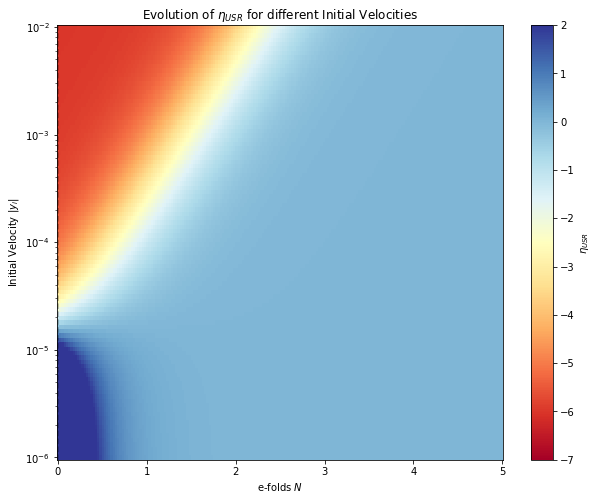

In [7]:
plt.figure(figsize=(10, 8))

# Create meshgrid for plotting
X, Y = np.meshgrid(N_grid, np.abs(y_values))

# Plot heatmap
# We constrain vmin/vmax to highlight the -6 to 0 range
cp = plt.pcolormesh(X, Y, eta_matrix, cmap='RdYlBu', vmin=-7, vmax=2, shading='auto')
cbar = plt.colorbar(cp)
cbar.set_label(r'$\eta_{USR}$')

plt.yscale('log')
plt.xlabel("e-folds $N$")
plt.ylabel("Initial Velocity $|y_i|$")
plt.title(r"Evolution of $\eta_{USR}$ for different Initial Velocities")

plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

## 3. High-Res Minimum $\eta$ Plot

We also recreate the 1D transition plot with this high-density data to pinpoint the threshold.

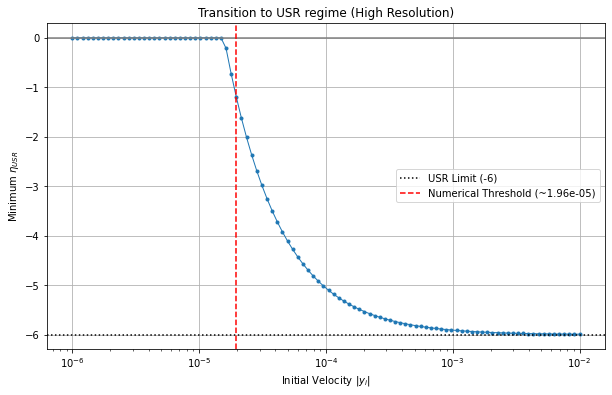

In [8]:
min_etas = np.min(eta_matrix, axis=1)

plt.figure(figsize=(10, 6))
plt.semilogx(np.abs(y_values), min_etas, '.-', lw=1)

plt.axhline(-6, color='k', linestyle=':', label='USR Limit (-6)')
plt.axhline(0, color='gray', linestyle='-')

# Locate numerical threshold (where min_eta drops below -1 for example)
# Find first index where min_eta < -1
idx_trans = np.where(min_etas < -1)[0]
if len(idx_trans) > 0:
    y_trans = np.abs(y_values[idx_trans[0]])
    plt.axvline(y_trans, color='r', linestyle='--', label=f'Numerical Threshold (~{y_trans:.2e})')

plt.xlabel("Initial Velocity $|y_i|$")
plt.ylabel(r"Minimum $\eta_{USR}$")
plt.title("Transition to USR regime (High Resolution)")
plt.legend()
plt.grid(True)
plt.show()

## 4. Duration of USR Phase

Another useful metric is the "duration" of the USR phase. How many e-folds does the field spend with $\eta < -5$?

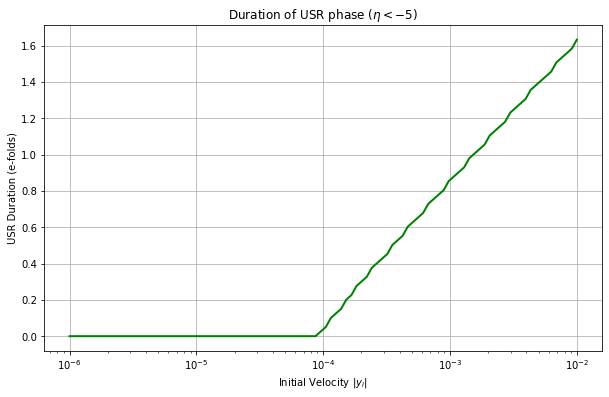

In [9]:
# Calculate duration (in e-folds) where eta < -5
duration_usr = []
for i in range(len(y_values)):
    # Boolean mask for USR condition
    is_usr = eta_matrix[i, :] < -5
    # Integrate N over this region (approx sum of dN)
    # Since N_grid is uniform, dN is constant
    dN = N_grid[1] - N_grid[0]
    dur = np.sum(is_usr) * dN
    duration_usr.append(dur)

plt.figure(figsize=(10, 6))
plt.semilogx(np.abs(y_values), duration_usr, 'g-', lw=2)
plt.xlabel("Initial Velocity $|y_i|$")
plt.ylabel("USR Duration (e-folds)")
plt.title(r"Duration of USR phase ($\eta < -5$)")
plt.grid(True)
plt.show()

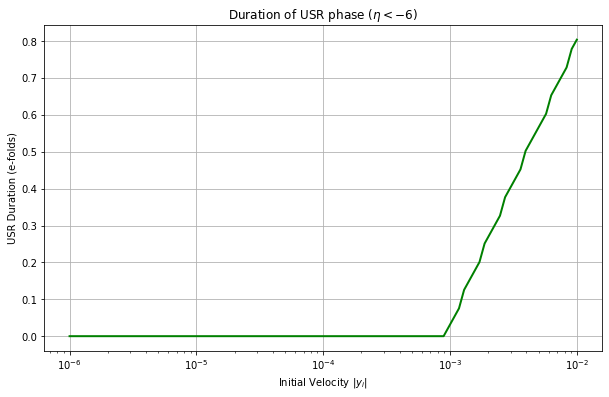

In [13]:
# Calculate duration (in e-folds) where eta < -6
duration_usr = []
for i in range(len(y_values)):
    # Boolean mask for USR condition: Modified threshold to -6
    is_usr = eta_matrix[i, :] < -5.9
    
    # Integrate N over this region (approx sum of dN)
    # Since N_grid is uniform, dN is constant
    dN = N_grid[1] - N_grid[0]
    dur = np.sum(is_usr) * dN
    duration_usr.append(dur)

plt.figure(figsize=(10, 6))
plt.semilogx(np.abs(y_values), duration_usr, 'g-', lw=2)
plt.xlabel("Initial Velocity $|y_i|$")
plt.ylabel("USR Duration (e-folds)")
# Updated title to reflect the -6 threshold
plt.title(r"Duration of USR phase ($\eta < -6$)")
plt.grid(True)
plt.show()